In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
import keras
from keras.applications.mobilenet import MobileNet

from sklearn.metrics import confusion_matrix
from keras.layers.core import Dense, Activation
from keras.metrics import categorical_crossentropy
from keras.metrics import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
from keras.preprocessing import image

In [4]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
)
validation_datagen = image.ImageDataGenerator(
    rescale = 1./255
)

In [5]:
train = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Brain Tumar Data set/Dataset/New folder (2)/Train',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

validation = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Brain Tumar Data set/Dataset/New folder (2)/Validation',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

test = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Brain Tumar Data set/Dataset/New folder (2)/Test',
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False,
    class_mode = 'categorical'
)

Found 2180 images belonging to 3 classes.
Found 306 images belonging to 3 classes.
Found 629 images belonging to 3 classes.


In [6]:
MobileNetv2 = tf.keras.applications.MobileNetV2(
    include_top=False, 
    weights = 'imagenet', 
    input_shape=(224,224,3),
    )

9406464/9406464 [==============================] - 0s 0us/step


In [7]:
MobileNetv2.trainable = False

In [12]:
model = tf.keras.models.Sequential([
  MobileNetv2,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=3, activation='softmax'), 
])

In [13]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_1 (Dropout)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              64226304  
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                      

In [14]:
history = model.fit(
    x = train, 
    validation_data = validation,
    epochs = 10
)

Epoch 1/10
69/69 [==============================] - 688s 10s/step - loss: 3.2914 - accuracy: 0.7197 - val_loss: 1.0946 - val_accuracy: 0.6176
Epoch 2/10
69/69 [==============================] - 149s 2s/step - loss: 0.5585 - accuracy: 0.8284 - val_loss: 1.3878 - val_accuracy: 0.5915
Epoch 3/10
69/69 [==============================] - 154s 2s/step - loss: 0.3852 - accuracy: 0.8642 - val_loss: 1.1325 - val_accuracy: 0.6242
Epoch 4/10
69/69 [==============================] - 142s 2s/step - loss: 0.2732 - accuracy: 0.8927 - val_loss: 0.8623 - val_accuracy: 0.7124
Epoch 5/10
69/69 [==============================] - 151s 2s/step - loss: 0.2486 - accuracy: 0.9124 - val_loss: 0.9565 - val_accuracy: 0.7059
Epoch 6/10
69/69 [==============================] - 143s 2s/step - loss: 0.2714 - accuracy: 0.8945 - val_loss: 1.0129 - val_accuracy: 0.6895
Epoch 7/10
69/69 [==============================] - 147s 2s/step - loss: 0.2726 - accuracy: 0.9046 - val_loss: 1.1828 - val_accuracy: 0.6242
Epoch 8/10
6

In [15]:
# Evaluate the loss and accuracy
loss, accuracy = model.evaluate(test)

# Print the accuracy
print("Accuracy: " + str(accuracy))
# Print the loss
print("Loss: " + str(loss))

20/20 [==============================] - 192s 10s/step - loss: 0.4513 - accuracy: 0.8426
Accuracy: 0.842607319355011
Loss: 0.4512607455253601


In [16]:
test.class_indices

{'glioma': 0, 'meningioma': 1, 'pituitary_tumor': 2}

In [17]:
import numpy as np
from sklearn import metrics

predictions = model.predict(test)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test.classes
class_labels = ['glioma', 'meningioma', 'pituitary_tumor']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

20/20 [==============================] - 32s 2s/step
                 precision    recall  f1-score   support

         glioma       0.93      0.82      0.87       291
     meningioma       0.69      0.72      0.71       152
pituitary_tumor       0.85      0.97      0.91       186

       accuracy                           0.84       629
      macro avg       0.82      0.84      0.83       629
   weighted avg       0.85      0.84      0.84       629



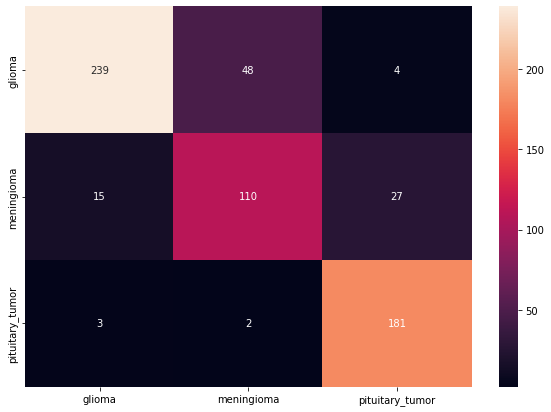

In [18]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['glioma', 'meningioma', 'pituitary_tumor']],
                  columns = [i for i in ['glioma', 'meningioma', 'pituitary_tumor']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

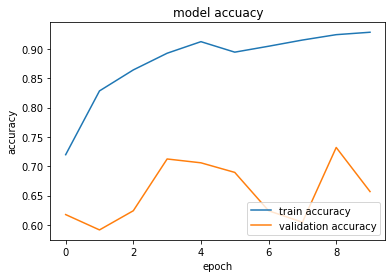

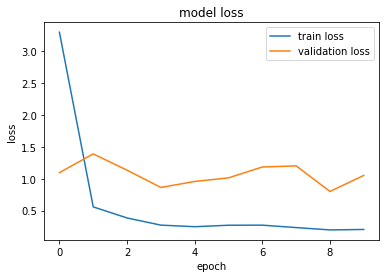

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuacy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()